In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
data_dir = 'dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

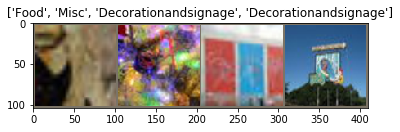

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# https://www.kaggle.com/usingtc/lenet-with-pytorch

In [8]:
import torch.nn.functional as F

I have resized my images to 100 X 100

In [9]:
class LeNet(nn.Module):
	def __init__(self,numberOfClasses):
		super(LeNet, self).__init__()
		self.conv1 = nn.Conv2d(3, 6, (5,5), padding=0) # conv2d(inputChannels, outputchannels,(filter size),paddng)
		self.conv2 = nn.Conv2d(6, 16, (5,5))
		self.fc1   = nn.Linear(16*22*22, 120)
		self.fc2   = nn.Linear(120, 84)
		self.fc3   = nn.Linear(84, numberOfClasses)
	def forward(self, x):
		x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
		x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
		x = x.view(-1, self.num_flat_features(x))
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x
	def num_flat_features(self, x):
		size = x.size()[1:]
		num_features = 1
		for s in size:
			num_features *= s
		return num_features

In [10]:
# help(nn.Conv2d)

In [11]:
num_epochs = 5
num_classes = 4
# batch_size = 100
learning_rate = 0.001

In [12]:
model = LeNet(num_classes).to(device)

In [13]:
from torchsummary import summary
summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 96, 96]             456
            Conv2d-2           [-1, 16, 44, 44]           2,416
            Linear-3                  [-1, 120]         929,400
            Linear-4                   [-1, 84]          10,164
            Linear-5                    [-1, 4]             340
Total params: 942,776
Trainable params: 942,776
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.66
Params size (MB): 3.60
Estimated Total Size (MB): 4.37
----------------------------------------------------------------


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
import time
import copy


In [17]:
model_conv = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3045 Acc: 0.3794
val Loss: 1.2766 Acc: 0.4235

Epoch 1/24
----------
train Loss: 1.2534 Acc: 0.4226
val Loss: 1.1691 Acc: 0.4769

Epoch 2/24
----------
train Loss: 1.2140 Acc: 0.4455
val Loss: 1.1544 Acc: 0.5086

Epoch 3/24
----------
train Loss: 1.1948 Acc: 0.4723
val Loss: 1.1481 Acc: 0.4908

Epoch 4/24
----------
train Loss: 1.1872 Acc: 0.4754
val Loss: 1.1151 Acc: 0.5114

Epoch 5/24
----------
train Loss: 1.1756 Acc: 0.4771
val Loss: 1.1259 Acc: 0.5142

Epoch 6/24
----------
train Loss: 1.1660 Acc: 0.4871
val Loss: 1.1519 Acc: 0.4936

Epoch 7/24
----------
train Loss: 1.1322 Acc: 0.5010
val Loss: 1.0998 Acc: 0.5220

Epoch 8/24
----------
train Loss: 1.1253 Acc: 0.5074
val Loss: 1.0913 Acc: 0.5214

Epoch 9/24
----------
train Loss: 1.1015 Acc: 0.5251
val Loss: 1.0977 Acc: 0.5147

Epoch 10/24
----------
train Loss: 1.1172 Acc: 0.5108
val Loss: 1.0858 Acc: 0.5264

Epoch 11/24
----------
train Loss: 1.1125 Acc: 0.5141
val Loss: 1.0890 Acc: 0.5292

Ep

Model is behaving terrible